In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from datetime import datetime, timedelta

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
columns_ = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_data = session.query(Measurements.date, Measurements.prcp).\
order_by(Measurements.date.desc()).all()

precip_data = session.query(Measurements.date, Measurements.prcp).\
order_by(Measurements.date.desc()).all()


In [14]:
# Calculate the date 1 year ago from the last data point in the database
precip_end = precip_data[0][0] 
precip_end  = datetime.strptime(precip_end, "%Y-%m-%d")
precip_start = precip_end - timedelta(days=365)
print(precip_start)
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurements.date, Measurements.prcp).\
order_by(Measurements.date.desc()).all()


2016-08-23 00:00:00


In [15]:
stmt = session.query(Measurements).statement
measurement_df = pd.read_sql_query(stmt, session.bind)

measurement_df
#precipdf = pd.DataFrame (prcp_data, columns = ["date", 'Precipation'])
precip_df = measurement_df[measurement_df['date'] >= '2016-08-23']
precip_df = precip_df.set_index("date")
precip_df = precip_df.sort_values("date")
precip_df = precip_df.fillna(value=0)
precip_df = precip_df.reset_index(inplace=False)
precip_df

,date,id,station,prcp,tobs
0,2016-08-23,2364,USC00519397,0.00,81.0
1,2016-08-23,8825,USC00517948,0.00,80.0
2,2016-08-23,14608,USC00519281,1.79,77.0
3,2016-08-23,7331,USC00514830,0.05,80.0
4,2016-08-23,5091,USC00513117,0.15,76.0
...,...,...,...,...,...
2225,2017-08-22,12186,USC00519523,0.00,82.0
2226,2017-08-23,7635,USC00514830,0.00,82.0
2227,2017-08-23,2724,USC00519397,0.00,81.0
2228,2017-08-23,12187,USC00519523,0.08,82.0


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

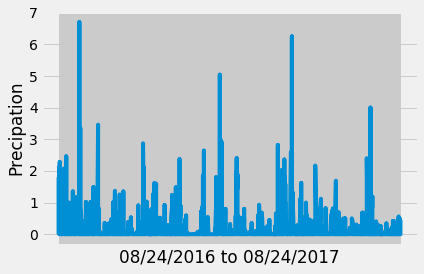

In [17]:
plt.plot(precip_df['date'],precip_df["prcp"] )
plt.tick_params(
    axis='x',
    which='both', 
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.xlabel("08/24/2016 to 08/24/2017")
plt.ylabel("Precipation")
plt.show()

In [18]:
prcp_summary = precip_df.describe().round(2)
del prcp_summary["id"]
del prcp_summary["tobs"]

In [19]:
prcp_summary

,prcp
count,2230.00
mean,0.16
std,0.44
min,0.00
25%,0.00
50%,0.01
75%,0.11
max,6.70


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurements.station).group_by(Measurements.station).distinct().count()

9

In [21]:
station_list= session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).all()
print(station_list)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [24]:
print (f"Station {station_list[0][0]} has the highest amount of data with {station_list[0][1]} results.")
most_active = station_list[0][0]

Station USC00519281 has the highest amount of data with 2772 results.


In [25]:
max_temp = session.query(Measurements.station, func.max(Measurements.tobs)).\
filter(Measurements.date>="2016-08-23)").all()
print (f"The maximum temperature recoreded in the past year was {max_temp[0][1]}.")

The maximum temperature recoreded in the past year was 87.0.


In [26]:
min_temp = session.query(Measurements.station, func.min(Measurements.tobs)).\
filter(Measurements.date>="2016-08-23)").all()
print (f"The minimum temperature recorded in the past year was {min_temp[0][1]}.")

The minimum temperature recorded in the past year was 58.0.


In [27]:
ave_temp = session.query(Measurements.station, func.avg(Measurements.tobs)).\
filter(Measurements.date>="2016-08-23)").all()
print (f"The average temperature recoreded in the past year was {round(ave_temp[0][1],2)}.")

The average temperature recoreded in the past year was 74.58.


In [28]:
tobs_data = session.query(Measurements.tobs).\
filter(Measurements.station == 'USC00519281').\
filter(Measurements.date>="2016-08-23)").all()

In [29]:
df_tobs = pd.DataFrame(tobs_data, columns=["Temperature"])
df_tobs

,Temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


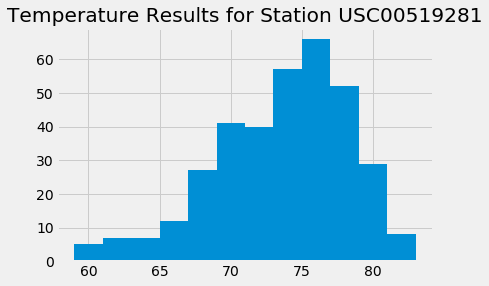

In [30]:
plt.hist(x="Temperature", data=df_tobs, bins=12)
plt.title("Temperature Results for Station USC00519281")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
